In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle

In [2]:
# load STREaN data (STREaM is a simulator of end-uses and water demand patterns)
all_data_path = './data/allData.txt'

In [3]:
# Controls the pattern length
week_length = 7 
day_length = 24
number_of_weeks = 38 # roughly, 9 months

# We store the patterns into a .csv file
output_path = 'enhanced_ctown_38_weeks.csv'

# Create a water network model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# We get all the junctions in the topology
node_list = list(wn.node_name_list)
junction_list  = []
for node in node_list:
    if wn.get_node(node).node_type == 'Junction':
        junction_list.append(str(node))
        
numbers_of_junctions = len(junction_list)        
df = pd.read_csv(all_data_path, header=None)

C:\Users\Azulm\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning: Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


In [4]:
# Simulate hydraulics
sim = wntr.sim.WNTRSimulator(wn,mode='PDD')
results = sim.run_sim()

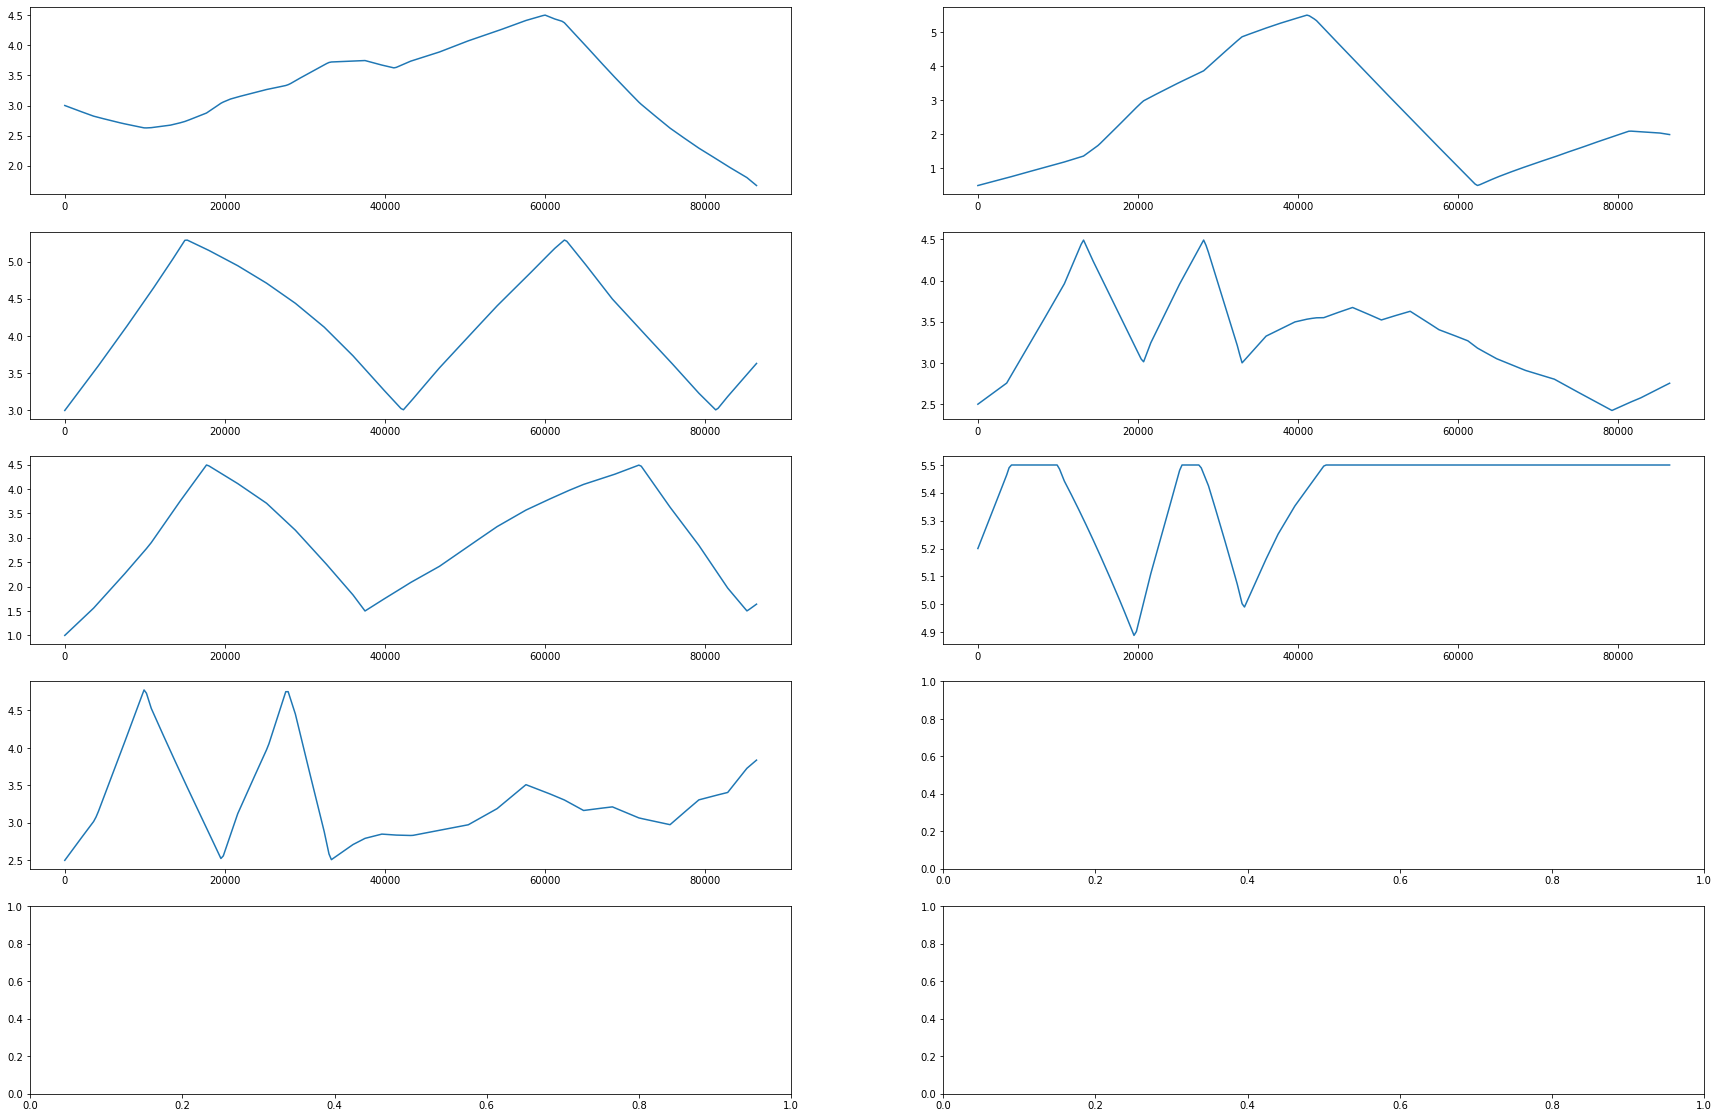

In [5]:
nr = 4
nc = 2
f, ax = plt.subplots(nr,nc,figsize=(30,20))
ax[0][0].plot(results.node['pressure']['T1'])
ax[0][1].plot(results.node['pressure']['T2'])
ax[1][0].plot(results.node['pressure']['T3'])
ax[1][1].plot(results.node['pressure']['T4'])
ax[2][0].plot(results.node['pressure']['T5'])
ax[2][1].plot(results.node['pressure']['T6'])
ax[3][0].plot(results.node['pressure']['T7'])

In [6]:
results.node['pressure']['T1']

0        3.000000
300      2.984865
600      2.969808
900      2.954831
1200     2.939931
           ...   
85200    1.805119
85500    1.772429
85800    1.739419
86100    1.706478
86400    1.673606
Name: T1, Length: 289, dtype: float64

In [7]:
# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
# reverse df and change df columns
df = df.T
df.columns = headers

In [9]:
# remove first 10 of each class
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [10]:
#length of patterns
n_hours = day_length*week_length*number_of_weeks
# total number of nodes and get nodes for each type of users
n_nodes = 400 # original
composition = np.array([20,50,20,5,5])
assert(composition.sum()==100)
nodes_per_users = (composition/100*n_nodes).astype(int)
nodes_per_users[1]=nodes_per_users[1]+n_nodes-nodes_per_users.sum()
assert(nodes_per_users.sum()==n_nodes)
n_dict = dict((user, n_nodes) for (user, n_nodes) in zip(user_classes, nodes_per_users))

In [11]:
# ['node_%003d'%i for i in range(1,n_nodes+1)]
df_patterns = pd.DataFrame(index=range(n_hours))
for user_class in user_classes:
    these_cols = [col for col in headers if user_class in col]
    these_nodes = n_dict[user_class]
    df_patterns = pd.concat([df_patterns,df[these_cols].sample(these_nodes, axis=1).iloc[:n_hours, :]], axis=1)

In [12]:
df_patterns

,user_low_213,user_low_250,user_low_151,user_low_127,user_low_377,user_low_345,user_low_110,user_low_391,user_low_067,user_low_305,...,user_night_205,user_night_089,user_night_053,user_night_059,user_night_319,user_night_033,user_night_048,user_night_124,user_night_328,user_night_380
0,1.0,3.0,7.0,0.0,7.0,0.0,0.0,13.0,0.0,0.0,...,6.0,6.0000,0.0,2.000,24.0,6.000,4.00,0.0,0.000,7.000
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0,7.0,0.0,...,8.0,0.0000,0.0,8.000,2.0,0.000,6.00,0.0,0.000,12.000
2,2.0,0.0,0.0,6.0,0.0,8.0,0.0,1.0,0.0,5.0,...,0.0,34.2930,8.0,8.000,11.0,1.000,2.00,3.0,6.000,0.000
3,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,152.8900,0.0,0.000,15.0,0.000,0.00,6.0,1.000,2.000
4,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,...,5.0,7.8122,0.0,55.818,25.0,102.000,25.00,5.0,12.000,29.742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6379,1.0,2.0,3.0,1.0,1.0,1.0,5.0,0.0,0.0,0.0,...,1.0,153.0000,11.0,8.000,9.0,1.000,5.00,4.0,20.000,8.000
6380,0.0,1.0,1.0,0.0,0.0,1.0,5.0,1.0,2.0,0.0,...,50.0,20.0000,21.0,28.000,1.0,113.000,6.00,1.0,11.000,1.000
6381,4.0,3.0,0.0,0.0,0.0,8.0,0.0,1.0,5.0,1.0,...,133.0,9.0000,15.0,2.000,1.0,1.000,7.00,4.0,60.000,55.000
6382,9.0,5.0,0.0,1.0,0.0,1.0,2.0,5.0,0.0,0.0,...,1.0,7.0000,5.0,1.000,7.0,1.000,7.00,13.0,14.000,1.000


In [14]:
pat_name = []
for i in range(1,334+1):
    pat_name.append('pat' + str(i))

In [15]:
cols =df_patterns.columns.to_list()
shuffle(cols)
df_patterns = df_patterns[cols]
dff = pd.DataFrame(index=df_patterns.index,columns=pat_name)
print(dff)

     pat1 pat2 pat3 pat4 pat5 pat6 pat7 pat8 pat9 pat10  ... pat325 pat326  \
0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
1     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
2     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
3     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
4     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...    ...    ...   
6379  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
6380  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
6381  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
6382  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   
6383  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN  ...    NaN    NaN   

     pat327 pat328 pat329 pat330 pat331 pat332 pat333 pat334  


In [16]:
for i in range(0,84):
    dff['pat' + str( (i*4)+1)]=df_patterns.iloc[:,:100].sum(axis=1)
    dff['pat' + str( (i*4)+2)]=df_patterns.iloc[:,100:200].sum(axis=1)
    dff['pat' + str( (i*4)+3)]=df_patterns.iloc[:,200:300].sum(axis=1)
    dff['pat' + str( (i*4)+4)]=df_patterns.iloc[:,300:400].sum(axis=1)

In [17]:
del dff['pat335']
del dff['pat336']

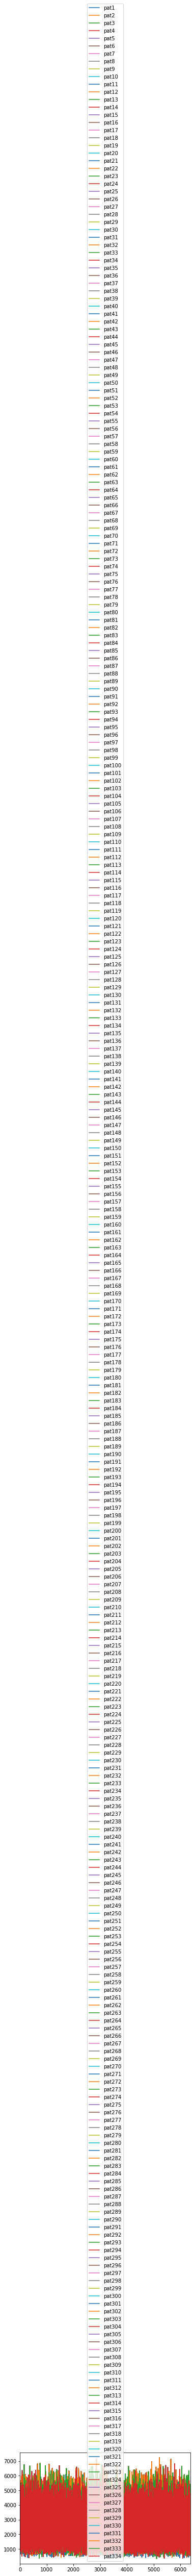

In [18]:
dff.plot()

In [19]:
# Write the resulting patterns
dff.to_csv(output_path)

In [20]:
# Plot original pattern
df_old = wntr_utils.get_demand_patterns_from_nodes(wn)

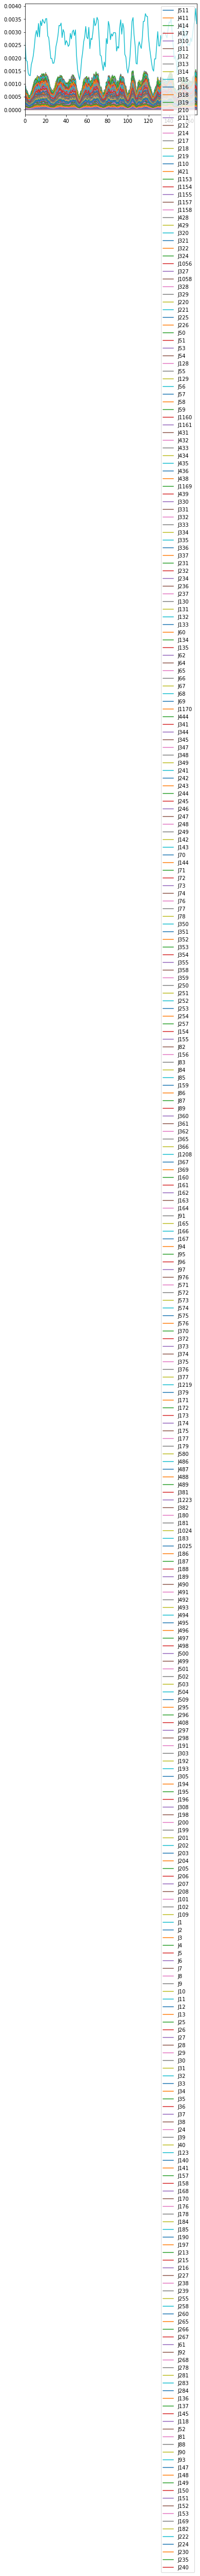

In [23]:
df_old.plot()

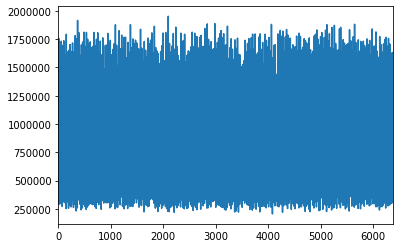

In [22]:
dff.sum(axis=1).plot()


<<< New Demands (top 5) >>>
pat68     6.831112
pat64     6.831112
pat208    6.831112
pat84     6.831112
pat212    6.831112
dtype: float64


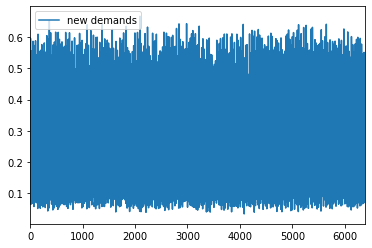

In [24]:
### load new demands
df_new = dff
d_max = 0.0025
constant = 0.00
scaler = MinMaxScaler(feature_range=(0, d_max))
temp = scaler.fit_transform(df_new.values.reshape(-1,1))
df_scaled = pd.DataFrame(columns = df_new.columns, data = temp.reshape(df_new.shape))+constant
print("\n<<< New Demands (top 5) >>>")
print(df_scaled.sum().sort_values(ascending=False).head())
df_scaled.sum(axis=1).plot(label = 'new demands')
plt.legend()

In [25]:
### substitute new demands
juncs = df_old.columns
juncs = juncs[(df_old.sum()>0).values] # these are the demand nodes
len(juncs)

334

In [26]:
assert(len(juncs)==df_scaled.shape[1]) # check if they match columns in new demands

{'J511': 'pat1', 'J411': 'pat2', 'J414': 'pat3', 'J417': 'pat4', 'J310': 'pat5', 'J311': 'pat6', 'J312': 'pat7', 'J313': 'pat8', 'J314': 'pat9', 'J315': 'pat10', 'J316': 'pat11', 'J318': 'pat12', 'J319': 'pat13', 'J210': 'pat14', 'J211': 'pat15', 'J212': 'pat16', 'J214': 'pat17', 'J217': 'pat18', 'J218': 'pat19', 'J219': 'pat20', 'J110': 'pat21', 'J421': 'pat22', 'J1153': 'pat23', 'J1154': 'pat24', 'J1155': 'pat25', 'J1157': 'pat26', 'J1158': 'pat27', 'J428': 'pat28', 'J429': 'pat29', 'J320': 'pat30', 'J321': 'pat31', 'J322': 'pat32', 'J324': 'pat33', 'J1056': 'pat34', 'J327': 'pat35', 'J1058': 'pat36', 'J328': 'pat37', 'J329': 'pat38', 'J220': 'pat39', 'J221': 'pat40', 'J225': 'pat41', 'J226': 'pat42', 'J50': 'pat43', 'J51': 'pat44', 'J53': 'pat45', 'J54': 'pat46', 'J128': 'pat47', 'J55': 'pat48', 'J129': 'pat49', 'J56': 'pat50', 'J57': 'pat51', 'J58': 'pat52', 'J59': 'pat53', 'J1160': 'pat54', 'J1161': 'pat55', 'J431': 'pat56', 'J432': 'pat57', 'J433': 'pat58', 'J434': 'pat59', 'J435

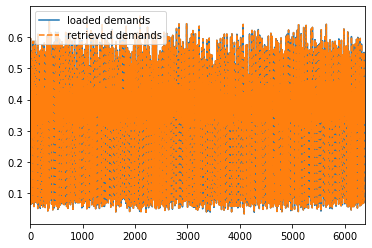

In [27]:
d_juncs = dict(zip(juncs,df_scaled.columns)) # match each demand node with new demand

# remove old patterns
for name in wn.junction_name_list:
    junc = wn.get_node(name)
    junc.demand_timeseries_list.pop()

print("Removed old patterns")
    
for name in df_scaled.columns:
    wn.add_pattern(name=name, pattern=df_scaled[name].values)

print("Added new patterns")

for name in juncs:
    junc = wn.get_node(name)
    junc.add_demand(1,d_juncs[name])    

print("Added demands")    

# check if demands coincide
df_check = wntr_utils.get_demand_patterns_from_nodes(wn)
plt.figure()
df_scaled.sum(axis=1).plot(label = 'loaded demands')
df_check.sum(axis=1).plot(label = 'retrieved demands', **{'linestyle':'dashed'})
plt.legend()

In [28]:
print(wn.options.time.duration)
print(wn.options.time.hydraulic_timestep)

86400
300


In [29]:
# Simulate hydraulics
sim_2 = wntr.sim.WNTRSimulator(wn,mode='PDD')
results_2 = sim.run_sim()

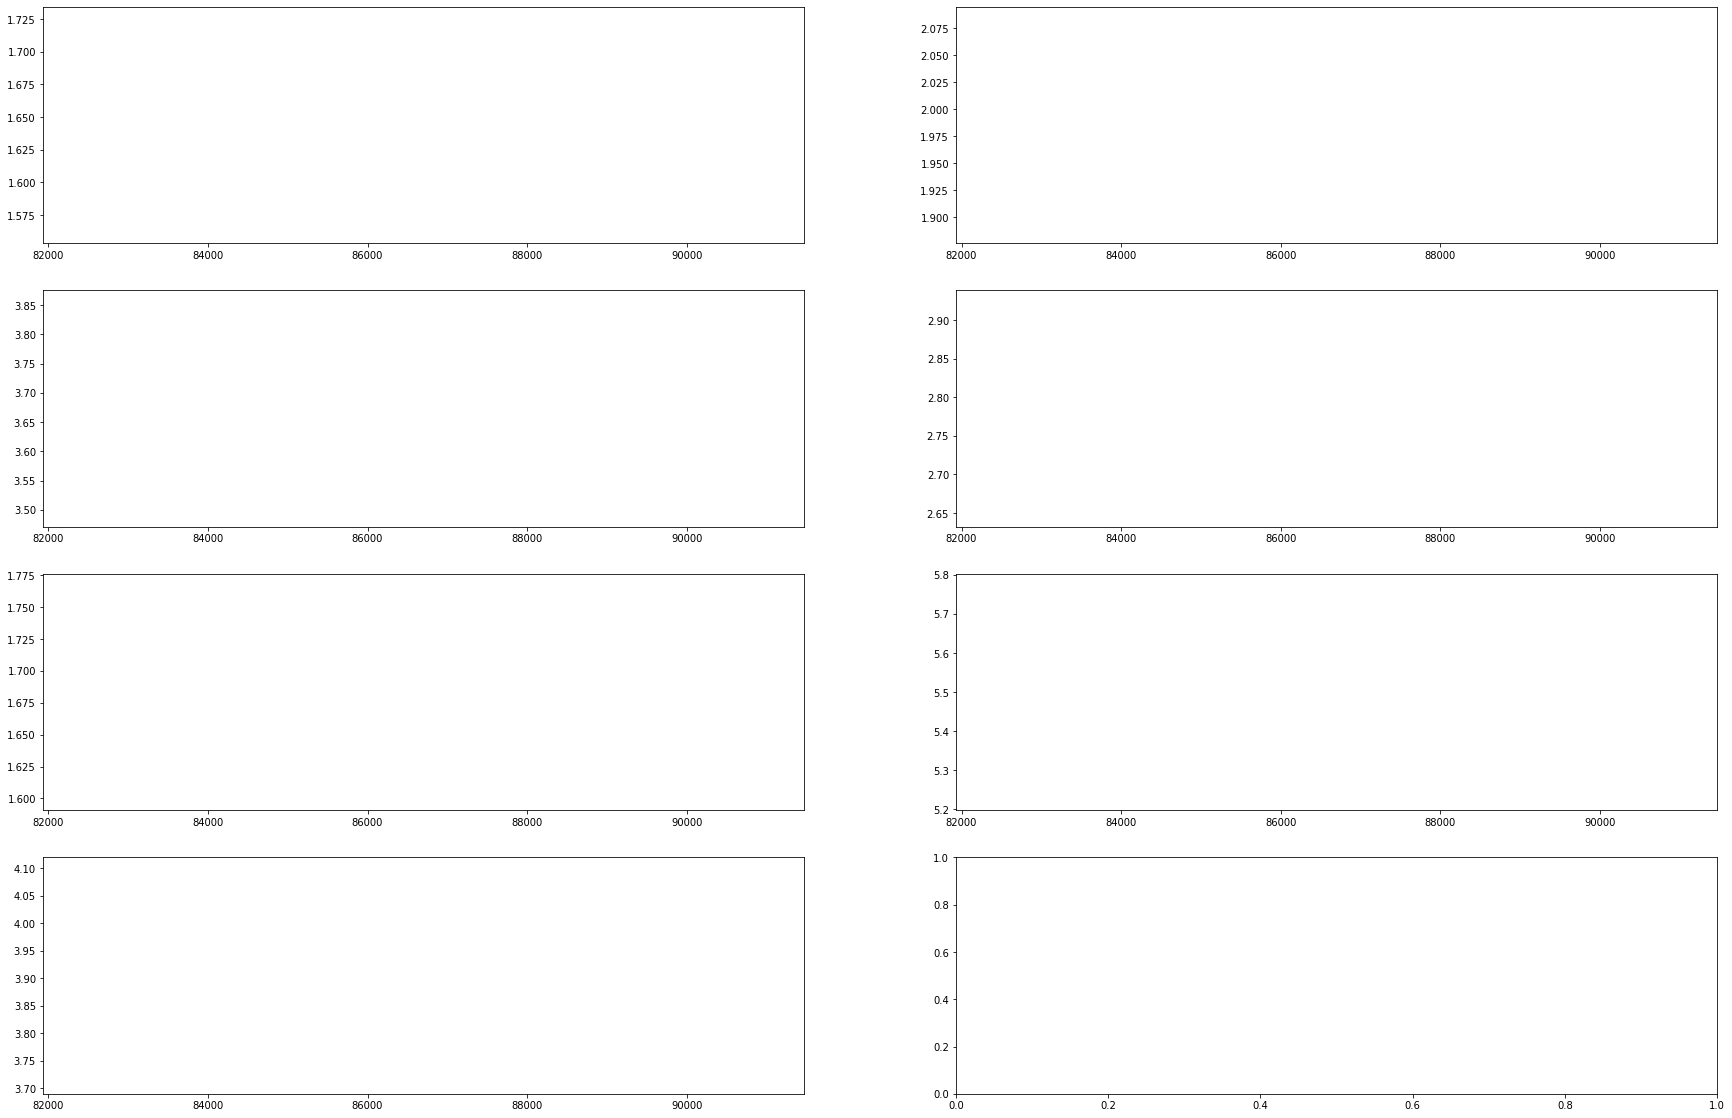

In [32]:
nr = 4
nc = 2
f, ax = plt.subplots(nr,nc,figsize=(30,20))
ax[0][0].plot(results_2.node['pressure']['T1'])
ax[0][1].plot(results_2.node['pressure']['T2'])
ax[1][0].plot(results_2.node['pressure']['T3'])
ax[1][1].plot(results_2.node['pressure']['T4'])
ax[2][0].plot(results_2.node['pressure']['T5'])
ax[2][1].plot(results_2.node['pressure']['T6'])
ax[3][0].plot(results_2.node['pressure']['T7'])

In [33]:
results_2.node['pressure']['T1']

0        3.000000
300      2.984865
600      2.969808
900      2.954831
1200     2.939931
           ...   
85200    1.805119
85500    1.772429
85800    1.739419
86100    1.706478
86400    1.673606
Name: T1, Length: 289, dtype: float64

Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error excepted
Index Error e

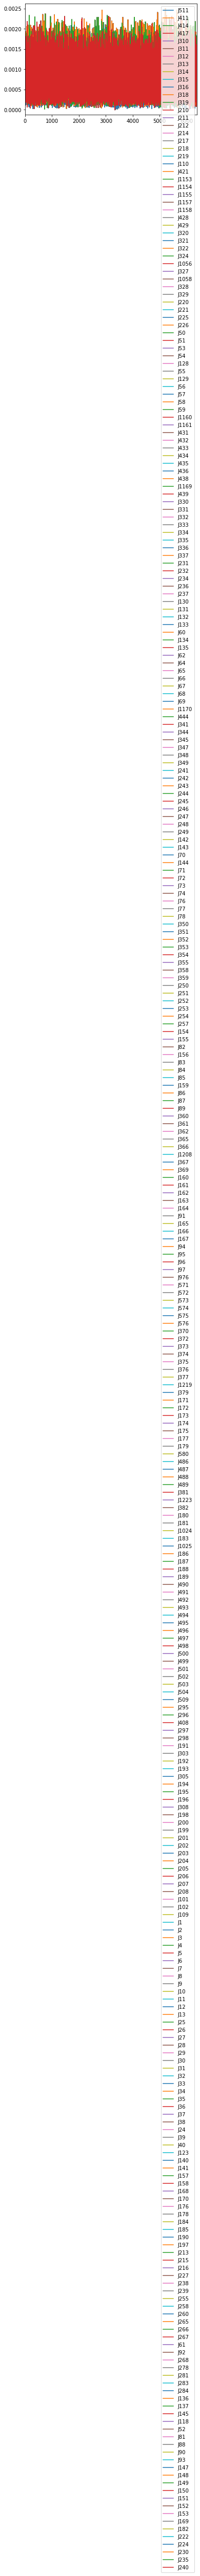

In [34]:
wntr_utils.get_demand_patterns_from_nodes(wn).plot()